<a href="https://colab.research.google.com/github/shinnew9/Apziva_practice_code/blob/main/Project4-MonReader/2nd_TransferLearning_EfficientNet%2CResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Necessary Packages

In [2]:
!pip install ace_tools --quiet
!pip install easyocr --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [3]:
!pip install gTTS --quiet

In [4]:
import os
import glob
import pandas as pd

from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from torchvision import transforms
from PIL import Image

#### Open data

In [5]:
extract_dir = "/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images"

# Check directory structure after extraction
training_path = os.path.join(extract_dir, "images", "training")
test_path = os.path.join(extract_dir, "images", "testing")

# Checking the number of photos
# Use glob.glob instead of glob
training_images = glob.glob(os.path.join(training_path, "**", "*.jpg"), recursive=True)
test_images = glob.glob(os.path.join(test_path, "**", "*.jpg"), recursive=True)

print(f"🖼️ Training images found: {len(training_images)}")
print(f"🖼️ Testing images found: {len(test_images)}")

🖼️ Training images found: 2392
🖼️ Testing images found: 597


In [6]:
def get_label_from_path(path):
    return "flip" if "/flip/" in path else "notflip"

df_train = pd.DataFrame({
    "filepath": training_images,
    "label": [get_label_from_path(p) for p in training_images]
})

df_test = pd.DataFrame({
    "filepath": test_images,
    "label": [get_label_from_path(p) for p in test_images]
})

df_train.head()

,filepath,label
0,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
1,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
2,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
3,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
4,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip


In [12]:
df_test.head()

,filepath,label
0,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
1,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
2,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
3,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip
4,/content/drive/MyDrive/Apziva/4th_MonReader/mo...,flip


In [16]:
# Image size and transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

class FlipDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"flip": 1, "notflip": 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filepath"]
        label = self.label_map[self.df.loc[idx, "label"]]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


train_dataset = FlipDataset(df_train, transform=transform)
test_dataset = FlipDataset(df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Showing sample/random images

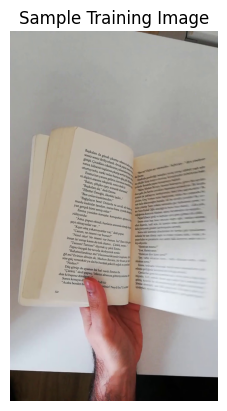

In [17]:
# sample image
from PIL import Image
import matplotlib.pyplot as plt

if training_images:
  img = Image.open(training_images[0])
  plt.imshow(img)
  plt.title("Sample Training Image")
  plt.axis("off")
  plt.show()
else:
  print("⚠️ No training images found.")

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

def show_random_images(label, df=df_train, num=5):
  subset = df[df["label"]==label].sample(n=num, random_state=42)
  plt.figure(figsize=(15, 3))
  for i, path in enumerate(subset["filepath"]):
    img = Image.open(path).convert("RGB")
    plt.subplot(1, num, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
  plt.tight_layout()
  plt.show()

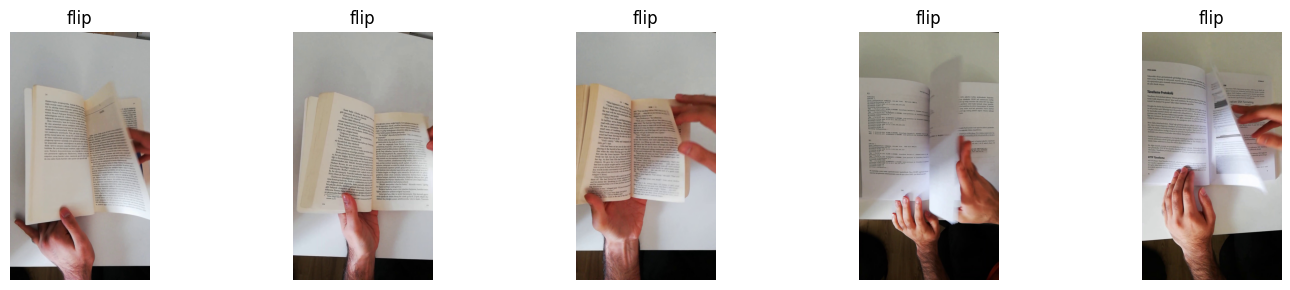

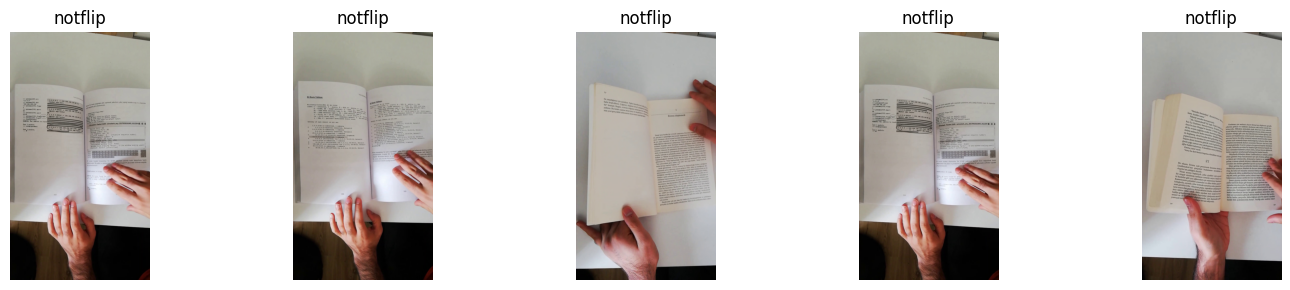

In [42]:
show_random_images("flip")
show_random_images("notflip")

#### Checking any overlapped Train/Test images

In [18]:
overlap = set(df_train["filepath"]) & set(df_test["filepath"])
print(f"🔍 Number of Overlapped Train/Test Images: {len(overlap)}")

🔍 Number of Overlapped Train/Test Images: 0


#### Validation dataset split

In [29]:
from sklearn.model_selection import train_test_split

df_train_split, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train["label"], random_state=42)

# Applying Transform
train_dataset = FlipDataset(df_train_split, transform=transform)
val_dataset = FlipDataset(df_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [35]:
print(df_train["label"].value_counts())

label
notflip    1230
flip       1162
Name: count, dtype: int64


### Transfer Learning - EfficientNet, ResNet

In [30]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet_b0
eff_model = models.efficientnet_b0(pretrained=True)
eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, 2)   # binary classification
eff_model = eff_model.to(device)

# ResNet50
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most u

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_eff = optim.Adam(eff_model.parameters(), lr = 1e-4)
optimizer_res = optim.Adam(resnet_model.parameters(), lr=1e-4)

In [32]:
import matplotlib.pyplot as plt


def train_model(model, optimizer, train_loader, val_loader, num_epochs=20, patience=3):
  best_loss = float('inf')
  patience_counter = 0
  model = model.to(device)

  # List for saving log

  train_losses = []
  val_losses = []
  train_accuracies = []


  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0


    for images, labels in train_loader:
      # I need to incorporate early stopping here, during the training, put the if block for every epochs
      # 200 images/ 500 updates, evaluate the model on the validation set, the loos on the validation set drops , align togehter it's fine
      # but if some point, the validation loss climbing up or accuracy drop,s if that happens, stop training, which is early stopiing
      # very commonly used to prevent overfitting
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader)

    # 🔍 Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for val_images, val_labels in val_loader:
        val_iamges, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        v_loss = criterion(val_outputs, val_labels)
        val_loss += v_loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Saving Log
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.4f}| Val Loss: {avg_val_loss:.4f}")


    # Early Stopping
    if avg_val_loss < best_loss:
      best_loss = avg_val_loss
      patience_counter = 0
      best_model_wts = model.state_dict()
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"🛑 Early stopping triggered at epoch {epoch+1}")
        model.load_state_dict(best_model_wts)
        break

  # 📈 Visualization
  epochs = range(1, len(train_losses)+1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label='Train Loss')
  plt.plot(epochs, val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss Over Epochs')
  plt.legend()



  # Accuracy Graph
  plt.plot(epochs, train_accuracies, label='Train Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy Over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()

  return model

Epoch [1/20] Train Loss: 0.3484 Acc: 0.8860| Val Loss: 0.0579
Epoch [2/20] Train Loss: 0.0625 Acc: 0.9885| Val Loss: 0.0160
Epoch [3/20] Train Loss: 0.0243 Acc: 0.9953| Val Loss: 0.0206
Epoch [4/20] Train Loss: 0.0104 Acc: 0.9984| Val Loss: 0.0076
Epoch [5/20] Train Loss: 0.0138 Acc: 0.9958| Val Loss: 0.0092
Epoch [6/20] Train Loss: 0.0100 Acc: 0.9974| Val Loss: 0.0014
Epoch [7/20] Train Loss: 0.0076 Acc: 0.9984| Val Loss: 0.0173
Epoch [8/20] Train Loss: 0.0049 Acc: 0.9984| Val Loss: 0.0141
Epoch [9/20] Train Loss: 0.0075 Acc: 0.9984| Val Loss: 0.0144
🛑 Early stopping triggered at epoch 9


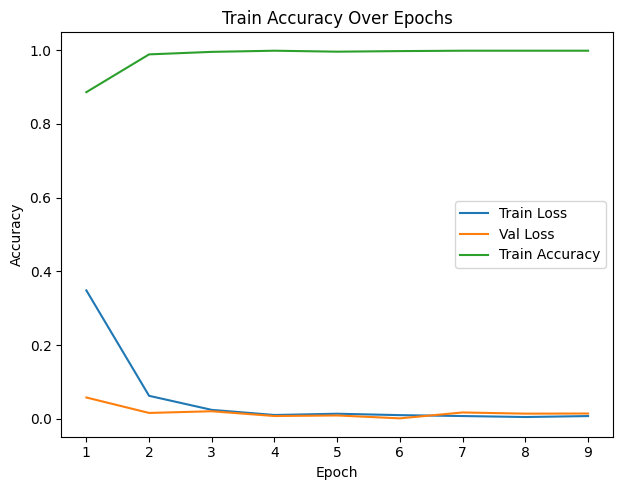

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
train_model(eff_model, optimizer_eff, train_loader, val_loader, num_epochs=20, patience=3)

In [24]:
# overfitting -> and if it was test set, th
# incorporating early stopping criteria
# how to do: let's say for every epochs,

print("Training EfficientNet...")
train_model(eff_model, optimizer_eff)

print("Training ResNet...")
train_model(resnet_model, optimizer_res)


# transfer leraning is about training the model for certain dataset, modify the architectures, add some layers for the classification purposes, and finetunie to the
# utilize the previosuly learned weights, transferring the learning from the imagenet to the customzied tasks
# the model is learned to the task and take the weights and

Training EfficientNet...


TypeError: train_model() missing 2 required positional arguments: 'train_loader' and 'val_loader'

Efficient Evaluation
              precision    recall  f1-score   support

     notflip       0.99      1.00      1.00       307
        flip       1.00      0.99      0.99       290

    accuracy                           0.99       597
   macro avg       1.00      0.99      0.99       597
weighted avg       1.00      0.99      0.99       597



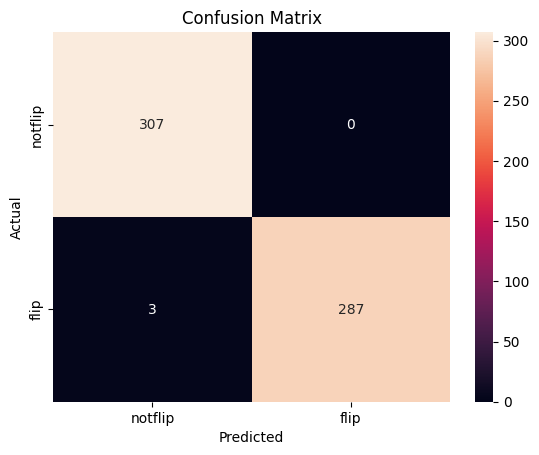

ResNet Evaluation
              precision    recall  f1-score   support

     notflip       0.51      0.84      0.63       307
        flip       0.46      0.15      0.22       290

    accuracy                           0.50       597
   macro avg       0.49      0.49      0.43       597
weighted avg       0.49      0.50      0.43       597



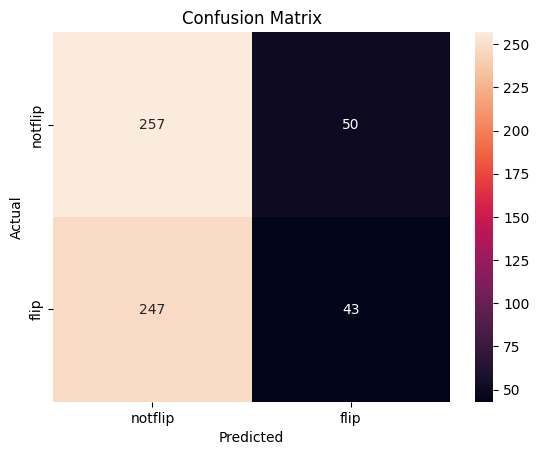

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.numpy())

  print(classification_report(all_labels, all_preds, target_names=["notflip", "flip"]))

  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=["notflip", "flip"], yticklabels=["notflip", "flip"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

# Evaluation Implement
print("Efficient Evaluation")
evaluate_model(eff_model)

print("ResNet Evaluation")
evaluate_model(resnet_model)